# Exploración de la epidemia de Covid19 en México

Casos de estudio reportados por la Secretaria de Salud de pacientes sospechos y confirmados de SARS-Cov2.

Tomados de https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico.

In [51]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import integrate, linalg, optimize, interpolate, loadtxt
from scipy import pi,array,zeros,eye,special,misc
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(13,8)})

In [2]:
# lectura de datos
ruta = os.path.join(os.getcwd(), 'data/covid19_consolidado.csv')
covid19 = pd.read_csv(ruta, encoding='latin-1',
                      parse_dates=['FECHA_ACTUALIZACION', 'FECHA_INGRESO', 'FECHA_SINTOMAS',
                                   'FECHA_DEF', 'FECHA_ACTUALIZACION_PREV', 'FECHA_DEF_PREV'])
covid19['FECHA_ACTUALIZACION'] = pd.to_datetime(covid19['FECHA_ACTUALIZACION'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_INGRESO'] = pd.to_datetime(covid19['FECHA_INGRESO'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_SINTOMAS'] = pd.to_datetime(covid19['FECHA_SINTOMAS'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_DEF'] = pd.to_datetime(covid19['FECHA_DEF'], format='%Y-%m-%d', errors='coerce')
covid19['FECHA_DEF_PREV'] = pd.to_datetime(covid19['FECHA_DEF_PREV'], format='%Y-%m-%d', errors='coerce')

In [3]:
# Estadistica descriptiva
covid19.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI,RESULTADO_PREV
count,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,...,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000,309601.000000
mean,1.636959,9.626616,14.884568,1.510854,16.367790,15.166463,37.130726,1.237322,74.452592,1.832788,...,2.473125,2.335193,2.191198,2.325677,2.273452,32.313355,1.859677,98.569036,74.450929,1.895572
std,0.480877,7.749124,7.962399,0.499883,11.610796,7.866836,48.102958,0.425442,40.440818,0.595132,...,6.975689,5.876445,5.859293,5.766722,5.902751,45.357832,0.689633,6.461983,40.444198,0.704472
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,9.000000,1.000000,9.000000,9.000000,7.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,99.000000,97.000000,1.000000
50%,2.000000,12.000000,14.000000,2.000000,15.000000,15.000000,20.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,97.000000,2.000000
75%,2.000000,12.000000,21.000000,2.000000,21.000000,21.000000,48.000000,1.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,99.000000,97.000000,2.000000
max,2.000000,99.000000,32.000000,2.000000,99.000000,32.000000,999.000000,2.000000,99.000000,99.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000,99.000000,3.000000


In [4]:
# tipos de datos
covid19.dtypes

FECHA_ACTUALIZACION         datetime64[ns]
ID_REGISTRO                         object
ORIGEN                               int64
SECTOR                               int64
ENTIDAD_UM                           int64
SEXO                                 int64
ENTIDAD_NAC                          int64
ENTIDAD_RES                          int64
MUNICIPIO_RES                      float64
TIPO_PACIENTE                        int64
FECHA_INGRESO               datetime64[ns]
FECHA_SINTOMAS              datetime64[ns]
FECHA_DEF                   datetime64[ns]
INTUBADO                             int64
NEUMONIA                             int64
EDAD                                 int64
NACIONALIDAD                         int64
EMBARAZO                             int64
HABLA_LENGUA_INDIG                   int64
DIABETES                             int64
EPOC                                 int64
ASMA                                 int64
INMUSUPR                             int64
HIPERTENSIO

In [5]:
covid19.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,FECHA_ACTUALIZACION_PREV,RESULTADO_PREV,FECHA_DEF_PREV
0,2020-06-02,16169f,2,3,27,2,27,27,13.0,1,...,2,2,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
1,2020-06-02,1009bf,2,4,14,2,14,14,39.0,1,...,2,99,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
2,2020-06-02,05d103,2,4,9,2,9,9,7.0,1,...,2,99,1,99,MÃ©xico,99,97,2020-06-01,1,NaT
3,2020-06-02,0d01b5,2,4,25,1,25,25,6.0,2,...,2,99,1,99,MÃ©xico,99,2,2020-06-01,1,2020-04-22
4,2020-06-02,002746,2,4,13,2,13,15,81.0,2,...,2,99,1,99,MÃ©xico,99,2,2020-06-01,1,2020-04-26


Registro de casos confirmados y sospechos de COVID19 durante el año corriente

In [122]:
reg_se = pd.pivot_table(covid19, values='ID_REGISTRO', index=['FECHA_SINTOMAS'], 
                        columns=['RESULTADO'], aggfunc='count', fill_value=0).reset_index()

In [127]:
reg_se.head()
reg_se.set_index('FECHA_SINTOMAS', inplace=True);

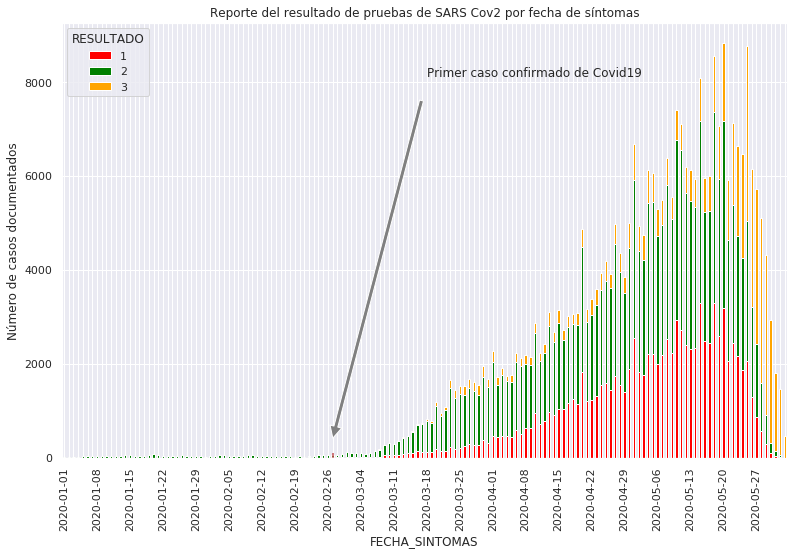

In [188]:
ax0 = reg_se.plot(kind='bar',stacked=True, color=['red','green', 'orange'])
ticklabels = ['']*len(reg_se.index)
skip = len(reg_se)//20
ticklabels[::skip] = reg_se.index[::skip].strftime('%Y-%m-%d')
ax0.xaxis.set_major_formatter(mticker.FixedFormatter(ticklabels))
plt.vlines(57, 0, 90, 'r')
ax0.annotate('Primer caso confirmado de Covid19', (56, 10),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='grey', shrink=0.05),
            fontsize=12,
            horizontalalignment='right', verticalalignment='top')
ax0.set_ylabel("Número de casos documentados");
ax0.set_title("Reporte del resultado de pruebas de SARS Cov2 por fecha de síntomas");

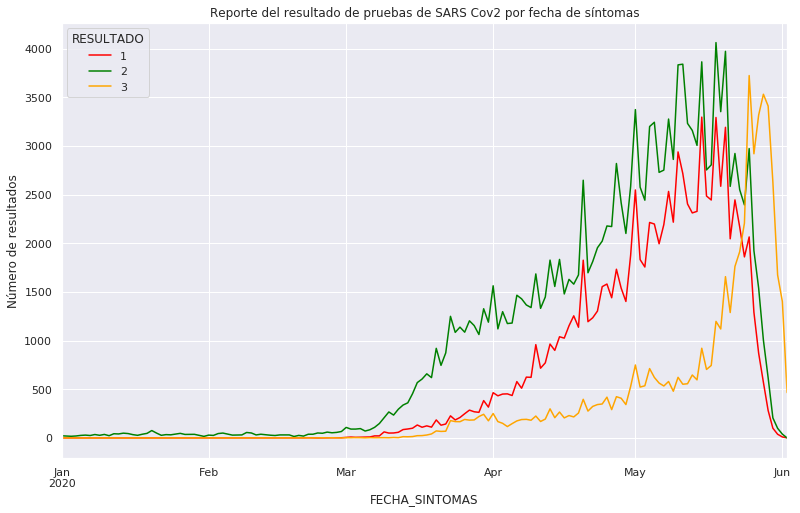

In [184]:
ax1 = reg_se.plot(color=['red', 'green', 'orange'])
ax1.set_ylabel("Número de resultados");
ax1.set_title("Reporte del resultado de pruebas de SARS Cov2 por fecha de síntomas");

In [189]:
covid_diarios = pd.read_csv('/home/ionekr/Documentos/Deformacion/Covid19/Datos/CASOS_DIARIOS_CONF.csv',
                           encoding='latin1')
covid_diarios['FECHA'] = pd.to_datetime(covid_diarios['FECHA'], format='%d-%m-%Y', errors='coerce')

In [190]:
covid_diarios.dtypes

FECHA        datetime64[ns]
NUM_CASOS             int64
dtype: object

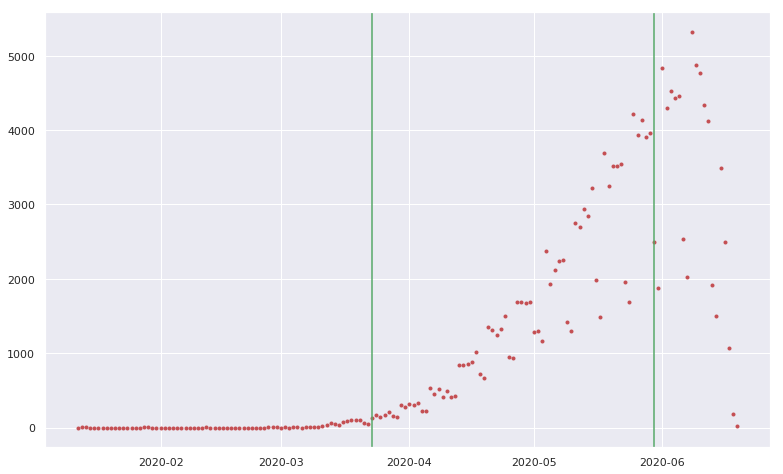

In [195]:
plt.plot(covid_diarios.FECHA, covid_diarios.NUM_CASOS, 'r.');
plt.axvline('23-03-2020', 0, 3000, color='g');
plt.axvline('30-05-2020', 0, 3000, color='g');

Modelos SEIR, y SIR

In [ ]:
# Modelo SEIR
def seir(y, t, p):
    f = np.zeros([4])
    betaIS = p[0]*y[0]*y[2]
    f[0] = -betaIS  # S
    f[1] = betaIS - 0.2*y[1]  # E
    f[2] = 0.2*y[1] - p[1]*y[2]  # I
    f[3] = p[1]*y[2]  # R
    return f

In [196]:
def seir_uno(y, t, p):
    f = np.zeros([4])
    betaIS = p[0]*y[0]*y[2]
    f[0] = -betaIS  # S
    f[1] = betaIS - 0.2*y[1]  # E
    f[2] = 0.2*y[1] - 0.5*y[2]  # I
    f[3] = 0.5*y[2]  # R
    return f

In [ ]:
# Modelo SEAIR
def seair(y, t, p):
    f = np.zeros([4])
    betaIS = p[0]*y[0]*y[3]
    f[0] = -betaIS  # S
    f[1] = betaIS - 0.2*y[1]  # E
    f[2] = (1 - p[2])*0.2*y[1] - p[1]*y[2]  # A
    f[3] = p[2]*0.2*y[1] - p[1]*y[3]  # I
    return f

In [322]:
def evaluador(model, t, p, y):    
    y = integrate.odeint(model, y, t, args=(p,))
    return y

In [198]:
class Poisson_DataFitter:

    def __init__(self, infectados, modelo, y0,  pu, pl, num_exp, tot_pob):
        self.infectados = infectados
        self.num_datos = len(self.infectados)
        self.tdata = np.linspace(0, self.num_datos, self.num_datos)
        self.logw = np.log(sum(special.factorial(self.infectados)))
        self.pl = pl
        self.pu = pu
        self.modelo = modelo
        self.num_exp = num_exp
        self.tot_pob = tot_pob
        if len(y0) == 4:
            #  Modelo SEIR
            self.ci = np.array([1-((self.num_exp*+1)*y0[0]/self.tot_pob),
                               y0[0]*self.num_exp/self.tot_pob,
                               y0[0]/self.tot_pob, 0.0])
        else:
            #  Modelo SIR
            self.ci = np.array([(1-y0[0]/self.tot_pob),
                               y0[0]/self.tot_pob, 0.0])

    def evaluate(self, p):
        y0 = integrate.odeint(self.modelo, self.ci, np.linspace(0.0, 100.0, 2000), args=(p,))[-1,:]        
        ySoln = integrate.odeint(self.modelo, self.ci, self.tdata, args=(p,))
        return ySoln
    
    def residue(self,p):
        ySoln = self.evaluate(p)[:,2]
        ind1 = np.where(ySoln<10**-8)
        ySoln[ind1] = np.ones(len(ind1))
        res = ySoln*self.tot_pob - self.infectados*np.log(ySoln*self.tot_pob) \
            + self.logw
        return sum(res)
    
    def error(self,p):
        try:
            abserror = self.residue(p)
        except ValueError:
            abserror = 10.0**10
        return abserror

In [ ]:
conteo_fs[(conteo_fs.RESULTADO==1) & (conteo_fs.FECHA_SINTOMAS>='2020-03-01')].NUM_CASOS.values

In [207]:
# Condiciones iniciales
pob_total = 127e6
num_exp = 8
inf_ini = 2
num_asin = 1
i0 = inf_ini/pob_total
e0 = inf_ini*num_exp/pob_total
a0 = 1/pob_total
y0 = np.array([1 - (i0 + e0 + a0), e0, a0, i0])
y0 = np.array([1 - (1+num_exp)*inf_ini/pob_total, num_exp*inf_ini/pob_total,
              inf_ini/pob_total, 0.0])

In [254]:
# Datos a procesar
datos = covid19[(covid19.RESULTADO == 1) & (covid19.FECHA_SINTOMAS>='2020-02-27') & (covid19.FECHA_SINTOMAS<'2020-03-23')].groupby(['FECHA_SINTOMAS']).size()

In [256]:
datos.count()

25

In [310]:
pu = np.array([1.33])
pl = np.array([1.27])
infectados = datos.values
poisson = Poisson_DataFitter(infectados, seir_uno, y0, pu, pl, num_exp, pob_total)

# poisson = Poisson_DataFitter(covid_datos, sir, z0, qu, ql, num_exp, pob_total)
Ninit = 100000
pmat = pl + abs(np.random.uniform(size=(Ninit,len(pl))))*(pu-pl)
rop = list(map(poisson.error, pmat))
bestguessindex = np.nonzero(rop==min(rop))
px = pmat[bestguessindex,:][0][0]
q = optimize.fmin(poisson.error, px)

In [311]:
px

array([1.32504069])

In [316]:
bestfit = np.array([1.32504069]) # No borrar

In [313]:
q0 = np.array([1.32343066])

In [323]:
t_eval = np.linspace(0, poisson.num_datos, poisson.num_datos)
res_px = evaluador(seir_uno, t_eval, px, y0)
res_q0 = evaluador(seir_uno, t_eval, q0, y0)

In [324]:
len(poisson.infectados)

25

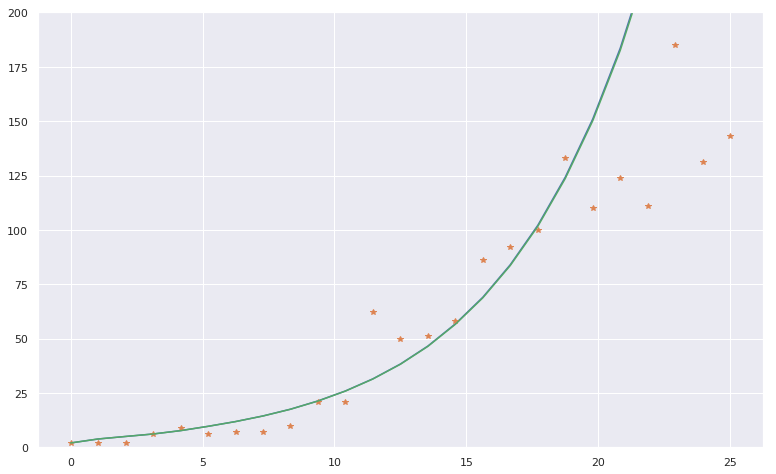

In [325]:
plt.plot(t_eval, res_px[:, 2]*pob_total, t_eval, poisson.infectados, '*', t_eval, res_q0[:, 2]*pob_total)
plt.ylim(0, 200)
plt.show()

In [327]:
t20 = np.linspace(0, 300, 300)
res20 = evaluador(seir_uno, t20, px, y0)

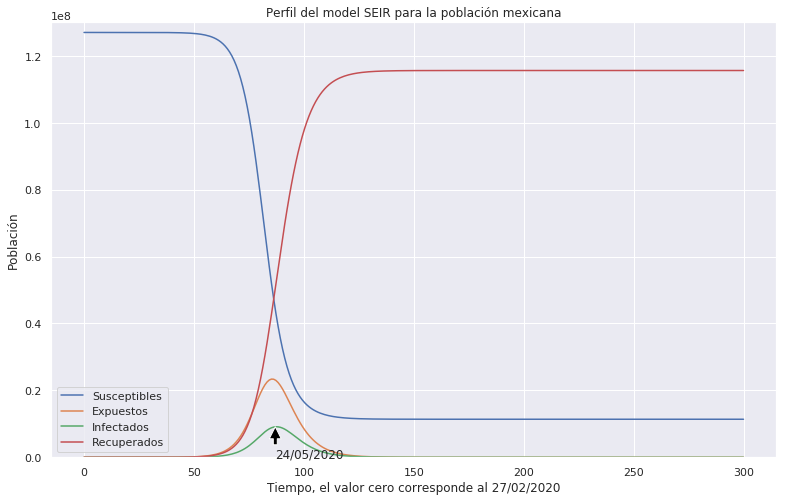

In [364]:
plt.plot(t20, res20[:, 0]*pob_total, t20, res20[:, 1]*pob_total, t20, res20[:, 2]*pob_total,
         t20, res20[:, 3]*pob_total,)
plt.ylim(0,130e6)
plt.legend(['Susceptibles', 'Expuestos', 'Infectados', 'Recuperados'])
plt.title("Perfil del model SEIR para la población mexicana")
plt.xlabel("Tiempo, el valor cero corresponde al 27/02/2020")
plt.ylabel("Población")
plt.annotate('24/05/2020', xy=(87, 9126072), xytext=(87, 1),
            arrowprops=dict(facecolor='black', shrink=0.0001),
            )
plt.show()

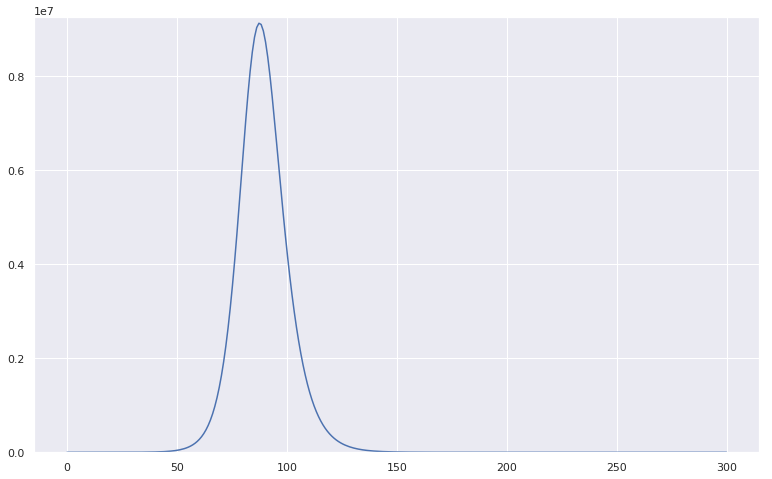

In [339]:
plt.plot(t20, res20[:, 2]*pob_total)
plt.ylim(0, 9.25e6)
plt.show()

In [346]:
np.nonzero(res20[:, 2] == max(res20[:, 2]))

(array([87]),)

In [356]:
max(res20[:, 2]*pob_total)

9126072.173135823

Ahora empleando los datos diarios

In [ ]:
pu = np.array([2.15, 0.7])
pl = np.array([1.65, 0.5])
infectados = covid_diarios.NUM_CASOS.values
poisson_conf = Poisson_DataFitter(infectados, seir, y0, pu, pl, num_exp, pob_total)
Ninit = 200
pmat = pl + abs(np.random.uniform(size=(Ninit,len(pl))))*(pu-pl)
rop = list(map(poisson_conf.error, pmat))
bestguessindex = np.nonzero(rop==min(rop))
px = pmat[bestguessindex,:][0][0]
q = optimize.fmin(poisson_conf.error, px)


In [ ]:
q

In [ ]:
px0 = np.array([2.08949959, 0.59424797])

In [ ]:
t_eval = np.linspace(0, poisson_conf.num_datos, poisson_conf.num_datos)
res_q = evaluador(seir, t_eval, px0, y0)

In [ ]:
plt.plot(t_eval, res_q[:, 0]*pob_total, t_eval, res_q[:, 1]*pob_total, t_eval, res_q[:, 2]*pob_total,
         t_eval, res_q[:, 3]*pob_total, t_eval, poisson_conf.infectados, '-.')
plt.ylim(0, 5000)
plt.show()